## Dispatchable Renewable Electricity Offers Higher Energy Return on Investment than Carbon Capture and Storage Under Realistic Conditions 
*Sgouridis, Carbajales-Dale, Csala, Chiesa, Bardi*

Use this Jupyter workbook to reproduce all results presented in the paper.

Import dependencies

In [144]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches
import matplotlib.lines as lines
%matplotlib inline
import sys
from sympy import *
init_printing() 
print 'Running on Python',sys.version

Running on Python 2.7.14 |Anaconda, Inc.| (default, Nov  8 2017, 13:40:45) [MSC v.1500 64 bit (AMD64)]


### Fossil fuels part

#### Equations

In [145]:
var('EROEI E_out E_in');
eq_S1=Eq(EROEI,E_out/E_in)
eq_S1

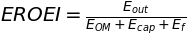

In [146]:
var('E_cap E_f E_OM');
eq_S1i=Eq(EROEI,E_out/(E_cap+E_OM+E_f))
eq_S1i

In [147]:
var('L s_OM');
eq_S2a=Eq(E_in,E_cap*(1+L*s_OM)+E_f)
eq_S2a

In [148]:
k=Symbol('kappa')
var('P L');
eq_S2b=Eq(E_out,P*k*L)
eq_S2b

In [149]:
var('E_el');
eq_S2bi=Eq(E_out,E_el)
eq_S2bi

In [150]:
e=Symbol('eta')
var('E_th');
eq_S2bii=Eq(E_th,P*k*L/e)
eq_S2bii

In [151]:
var('EROEI_th');
eq_S3i=Eq(E_f,E_th/EROEI_th)
eq_S3i

In [152]:
#define pretty variable substituion function
def sub(var,eq):
    return [var,solve(eq,var)[0]]
#create multiple substituion method by chaining
def multisub(eq0,msub):
    for i in range(len(msub)/2):
        eq0=eq0.subs([sub(msub[i*2],msub[i*2+1])])
    return eq0

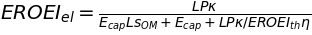

In [153]:
var('EROEI_el');
eq_S3=Eq(EROEI_el,multisub(eq_S1,[E_out,eq_S2b,E_in,eq_S2a,E_f,eq_S3i,E_th,eq_S2bii]).rhs)
eq_S3

In [154]:
#eq_S3 part 1 and eq_S4 not used

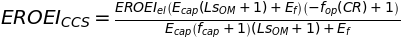

In [155]:
var('CR f_op EROEI_CCS f_cap');
eq_S5=Eq(EROEI_CCS,(1-f_op(CR))*(E_cap*(1+L*s_OM)+E_f)*EROEI_el/(E_cap*(1+f_cap)*(1+L*s_OM)+E_f))
eq_S5

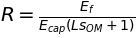

In [156]:
var('R');
eq_S6i=Eq(R,E_f/(E_cap*(1+L*s_OM)))
eq_S6i

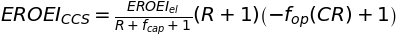

In [157]:
eq_S6=Eq(EROEI_CCS,(1-f_op(CR))*(R+1)*EROEI_el/(R+1+f_cap))
eq_S6

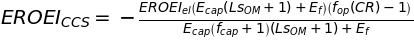

In [158]:
eq_S5.simplify()

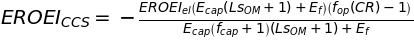

In [159]:
eq_S6.subs(R,eq_S6i.rhs).simplify()

In [160]:
#eq_S6 is correct!
eq_S6.subs(R,eq_S6i.rhs).simplify()==eq_S5.simplify()

True

#### Simulation

Using the formula in Eq.4 and the plant values from the Table S1 calculate the $EROEI_{el}$ for all capacity factors $CF$s between 50 and 90. We then use these values as a proxy to create an a adjustment factor for the $EROEI_{el}$ due to the indirect effect of the change of the capacity factor.

In [259]:
CFs=[50,55,60,65,70,75,80,85,90]
EROEI_els=[[8.8,9.2,8.8,10.7,11,26],
[9.2,9.6,9.2,11.2,11.5,27],
[9.6,10.1,9.7,11.6,12,27.8],
[10,10.5,10.1,12,12.4,28.6],
[10.3,10.8,10.5,12.4,12.8,29.3],
[10.7,11.1,10.8,12.7,13.2,29.9],
[11,11.5,11.2,13,13.5,30.5],
[11.2,11.7,11.5,13.3,13.8,31],
[11.5,12,11.8,13.5,14.1,31.5]]

In [260]:
df=pd.DataFrame(EROEI_els).T
df.columns=CFs
df.index.name='Plant #'
df.columns.name='CF'

In [261]:
df

CF,50,55,60,65,70,75,80,85,90
Plant #,,,,,,,,,
0,8.8,9.2,9.6,10.0,10.3,10.7,11.0,11.2,11.5
1,9.2,9.6,10.1,10.5,10.8,11.1,11.5,11.7,12.0
2,8.8,9.2,9.7,10.1,10.5,10.8,11.2,11.5,11.8
3,10.7,11.2,11.6,12.0,12.4,12.7,13.0,13.3,13.5
4,11.0,11.5,12.0,12.4,12.8,13.2,13.5,13.8,14.1
5,26.0,27.0,27.8,28.6,29.3,29.9,30.5,31.0,31.5


Capacity factor conversion ratio

In [262]:
(df[90]/df[50])/(90/50.0)

Plant #
0    0.726010
1    0.724638
2    0.744949
3    0.700935
4    0.712121
5    0.673077
dtype: float64

When we step up from CF 50 to 90, $EROEI_{el}$ only gets to 70% of what it should be using pure capacity factor conversion (90/50=1.8 multiplier). This is of course still dependent on the source EROEI, but let us use 0.7 for now, judging on the examined $EROEI$ ranges and the resultant conversion ratio values from the table above.

In [263]:
CF=[50,90]
CF_ratio=[1,0.7]

We need to create a similar ratio for the Capture ratio CR. We use the Energy penalty figure S1.

|CR | energy penalty  |
|--|--|
|50| 16  |
|90| 28|

In [264]:
CR=[90,50]
CR_ratio=[1, 16.0/28]

In [265]:
CR_ratio

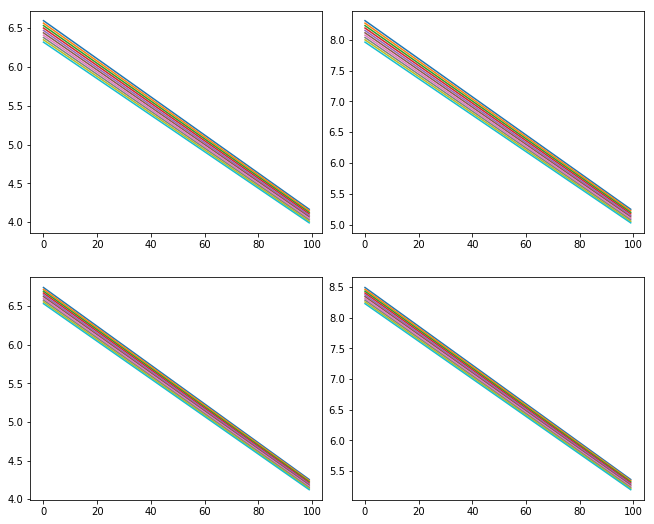

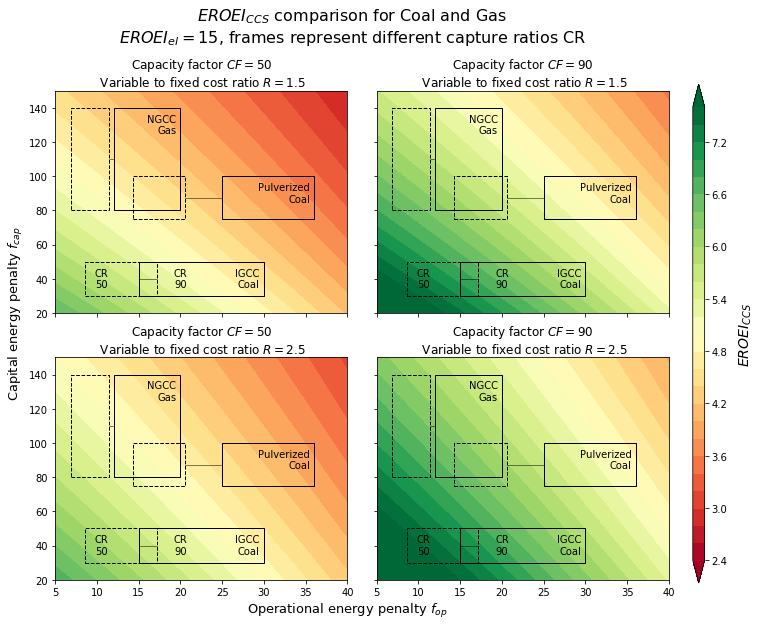

In [292]:
fop=np.linspace(5,40,100)
fcap=np.linspace(20,150,100)
RR=[[1.5,2.5],[2,3],[2,3],[1,2],[1,2]]
n=0
p=0
titles=[u'$EROEI_{CCS}$ comparison for Coal and Gas','Conventional Canadian Gas','Indiana Tight Gas','Coal','Coal']
eroei_els=[15,10,27,14,7]
names=['NGCC\nGas','Pulverized\nCoal','IGCC\nCoal']
t0s=[[12,20,80,140],[25,36,75,100],[15,30,30,50]]   
minmax=[{'min':0,'max':0} for i in range(4)]
#for r in range(len(titles)):
for r in range(1):
    R=RR[r]
    eroei_el=eroei_els[r]
    eroei_ccs=np.zeros([len(R),len(CF),len(fop),len(fcap)])
    for i in range(len(R)):
        for j in range(len(CF)):
            for k in range(len(fop)):
                for l in range(len(fcap)):
                    eroei_ccs[i][j][l,k]=(1-fop[k]/100.0)*((R[i]+1)/(R[i]+1+fcap[l]/100.0))*eroei_el*CF[j]*CF_ratio[j]/100.0
                    if ((i==1)and(j==1)):
                        if r==1:
                            n=0
                            p=0
                        elif r==2:
                            n=0
                            p=1
                        elif r==3:
                            n=2
                            p=2
                        elif r==4:
                            n=2
                            p=3
                        if ((abs(fop[k]-t0s[n][0])<0.5)and(abs(fcap[l]-t0s[n][2])<1.5)):
                            minmax[p]['max']=eroei_ccs[i][j][l,k]
                        if ((abs(fop[k]-t0s[n][1])<0.5)and(abs(fcap[l]-t0s[n][3])<1.5)):
                            minmax[p]['min']=eroei_ccs[i][j][l,k]

    fig,axes=plt.subplots(2,2,figsize=(11,9))
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.1)
    fig,axes2=plt.subplots(2,2,figsize=(11,9))
    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.1)
    for i in range(len(axes)):
        for j in range(len(axes[i])):
            z = eroei_ccs[i][j]
            for l in range(len(z[::10])):
                ax=axes[i][j]
                ax.plot(z[l])
            ax=axes2[i][j]
            levels = MaxNLocator(nbins=30).tick_values(eroei_el/6.0, eroei_el/2.0)
            cmap = plt.get_cmap('RdYlGn')
            X, Y = np.meshgrid(fop, fcap)
            im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')
            if (i==0)and(j==1):
                fig.subplots_adjust(right=0.9)
                cbar_ax = fig.add_axes([0.93, 0.12, 0.015, 0.77])
                fig.colorbar(im, cax=cbar_ax)
                cbar_ax.set_ylabel(u'$EROEI_{CCS}$',fontsize=14,labelpad=10)
            ax.set_xlim((fop.min(),fop.max()))
            ax.set_ylim((fcap.min(),fcap.max()))
            
            ls=['-','--']
            ls0='-'
            lw0=0.5
            for m in range(len(CR_ratio)):
                n=m*0
                for ti in range(len(t0s)):
                    if ((r==0)or(((r==1)or(r==2))and(ti==0))or(((r==3)or(r==4))and(ti!=0))):
                        t0=t0s[ti]
                        t=[t0[0]*CR_ratio[m],t0[1]*CR_ratio[m],t0[2]+n,t0[3]+n]
                        rect = patches.Rectangle((t[0],t[2]),t[1]-t[0],t[3]-t[2],linewidth=1,edgecolor='k',facecolor='none',ls=ls[m])
                        ax.add_patch(rect)
                        if ti==2:
                            ax.text(t[0]+2+(1-m)*3,t[3]-15,'CR\n'+str(CR[m]),horizontalalignment='center')
                        elif ti==0:
                            if ((r==1)or(r==2)):
                                ax.text(t[0]+2,t[3]-40,'CR\n'+str(CR[m]),horizontalalignment='center')
                        if m==0: 
                            ax.text(t[1]-0.5,t[3]-15,names[ti],horizontalalignment='right')
                        else:
                            line = lines.Line2D((t0[0],t[1]),((t0[2]+t0[3])/2,(t[2]+t[3])/2),color='k',linewidth=lw0,ls=ls0)
                            ax.add_line(line)  

            ax.set_title(u'Capacity factor $CF='+str(CF[j])+'$\n Variable to fixed cost ratio $R='+str(R[i])+'$')
    axes2[1][0].set_xlabel('Operational energy penalty $f_{op}$',fontsize=13,x=1)
    axes2[0][0].set_ylabel('Capital energy penalty $f_{cap}$',fontsize=13,y=0)        
    axes2[0][1].set_yticklabels('')   
    axes2[1][1].set_yticklabels('')   
    axes2[0][0].set_xticklabels('')   
    axes2[0][1].set_xticklabels('')  
    plt.suptitle(titles[r]+'\n'+r'$EROEI_{el}='+str(eroei_el)+'$, frames represent different capture ratios CR',fontsize=16,y=1.01)
    #plt.savefig(str(r)+'new2.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
    plt.show()

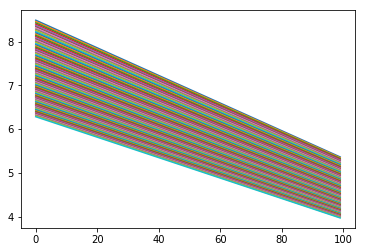

In [286]:
for l in range(len(eroei_ccs[i][j])):
    plt.plot(eroei_ccs[i][j][l])

In [ ]:
XXXXXXX

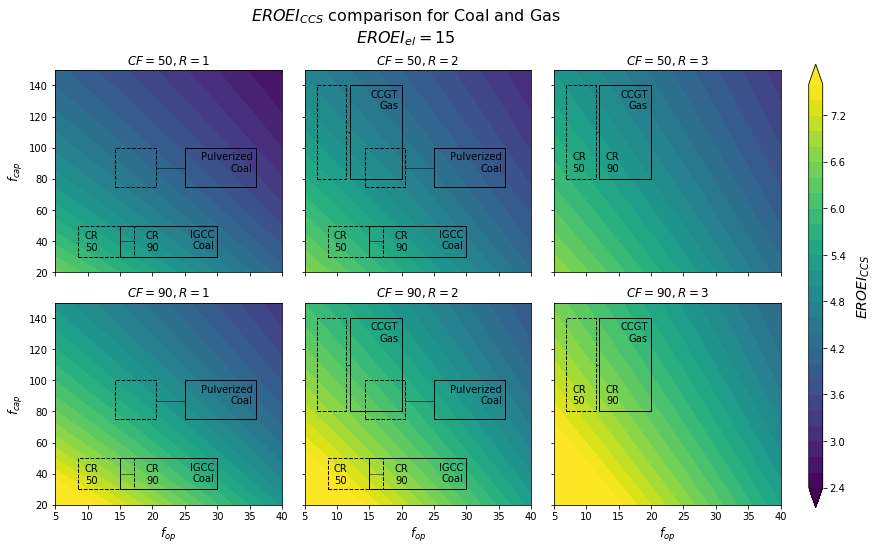

In [10]:
fop=np.linspace(5,40,100)
fcap=np.linspace(20,150,100)
R=[1,2,3]
n=0
p=0
titles=[u'$EROEI_{CCS}$ comparison for Coal and Gas']
eroei_els=[15]
names=['CCGT\nGas','Pulverized\nCoal','IGCC\nCoal']
t0s=[[12,20,80,140],[25,36,75,100],[15,30,30,50]]   
for r in range(len(titles)):
    eroei_el=eroei_els[r]
    eroei_ccs=np.zeros([len(R),len(CF),len(fop),len(fcap)])
    mmax=np.zeros([len(R),len(CF),len(CR_ratio),len(names)])
    mmin=np.zeros([len(R),len(CF),len(CR_ratio),len(names)])+1000
    for i in range(len(R)):
        for j in range(len(CF)):
            for k in range(len(fop)):
                for l in range(len(fcap)):
                    #calculate eoris over maps
                    eroei_ccs[i][j][l,k]=(1-fop[k]/100.0)*((R[i]+1)/(R[i]+1+fcap[l]/100.0))*eroei_el*CF[j]*CF_ratio[j]/100.0
                    
    fig,axes=plt.subplots(2,3,figsize=(13,8))
    plt.subplots_adjust(hspace=0.15)
    plt.subplots_adjust(wspace=0.1)
    for i in range(len(axes)):
        for j in range(len(axes[i])):
            ax=axes[i][j]
            z = eroei_ccs[j][i]
            levels = MaxNLocator(nbins=30).tick_values(eroei_el/6.0, eroei_el/2.0)
            cmap = plt.get_cmap('viridis')
            X, Y = np.meshgrid(fop, fcap)
            im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')
            if (i==0)and(j==1):
                fig.subplots_adjust(right=0.9)
                cbar_ax = fig.add_axes([0.93, 0.12, 0.015, 0.77])
                fig.colorbar(im, cax=cbar_ax)
                cbar_ax.set_ylabel(u'$EROEI_{CCS}$',fontsize=14,labelpad=10)
            ax.set_xlim((fop.min(),fop.max()))
            ax.set_ylim((fcap.min(),fcap.max()))

            ax.set_title(u'$CF='+str(CF[i])+', R='+str(R[j])+'$')
            
            ls=['-','--']
            ls0='-'
            lw0=0.5
            for m in range(len(CR_ratio)):
                n=m*0
                for ti in range(len(t0s)):
                    if (((j!=0)and(ti==0))or((j!=2)and(ti!=0))):
                        t0=t0s[ti]
                        t=[t0[0]*CR_ratio[m],t0[1]*CR_ratio[m],t0[2]+n,t0[3]+n]
                        rect = patches.Rectangle((t[0],t[2]),t[1]-t[0],t[3]-t[2],linewidth=1,edgecolor='k',facecolor='none',ls=ls[m])
                        ax.add_patch(rect)
                        if ti==2:
                            ax.text(t[0]+2+(1-m)*3,t[3]-16,'CR\n'+str(CR[m]),horizontalalignment='center')
                        if ((j==2)):
                            if ti==0:
                                ax.text(t[0]+2+(1-m)*0,t[3]-55,'CR\n'+str(CR[m]),horizontalalignment='center')
                        if m==0: 
                            ax.text(t[1]-0.5,t[3]-15,names[ti],horizontalalignment='right')
                        else:
                            line = lines.Line2D((t0[0],t[1]),((t0[2]+t0[3])/2,(t[2]+t[3])/2),color='k',linewidth=lw0,ls=ls0)
                            ax.add_line(line)  
                            
    axes[1][0].set_xlabel('$f_{op}$',fontsize=12)
    axes[1][1].set_xlabel('$f_{op}$',fontsize=12)
    axes[1][2].set_xlabel('$f_{op}$',fontsize=12)
    axes[0][0].set_ylabel('$f_{cap}$',fontsize=12)        
    axes[1][0].set_ylabel('$f_{cap}$',fontsize=12)        
    axes[0][1].set_yticklabels('')   
    axes[1][1].set_yticklabels('')   
    axes[0][2].set_yticklabels('')   
    axes[1][2].set_yticklabels('')   
    axes[0][0].set_xticklabels('')   
    axes[0][1].set_xticklabels('')  
    axes[0][2].set_xticklabels('')   
    plt.suptitle(titles[r]+'\n'+r'$EROEI_{el}='+str(eroei_el)+'$',fontsize=16,y=0.99)
    plt.savefig(str(r)+'b_new2.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
    plt.show()

### Dispatchable Renewables Part

#### Equations

#### Simulation

RE

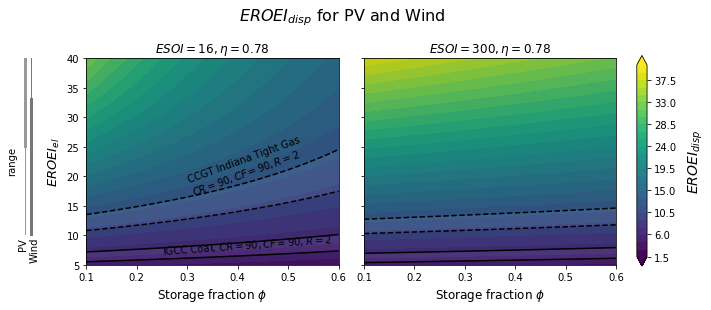

In [15]:
eroei_el=np.linspace(5,40,100)
phi=np.linspace(.10,.60,100)
ESOI=[16,300]
eta=0.78
eroei_disp=np.zeros([len(ESOI),len(phi),len(eroei_el)])
for i in range(len(ESOI)):
    for j in range(len(phi)):
        for k in range(len(eroei_el)):
            eroei_disp[i][k,j]=((1-phi[j])+(eta*phi[j]))/((1/eroei_el[k])+(eta*phi[j]/ESOI[i]))
fig,axes=plt.subplots(1,2,figsize=(9.5,3.8))
plt.subplots_adjust(wspace=0.1)
#levels = MaxNLocator(nbins=15).tick_values(4000, 15000)
for i in range(len(axes)):
    ax=axes[i]
    z = eroei_disp[i]
    levels = MaxNLocator(nbins=30).tick_values(2, 40)
    cmap = plt.get_cmap('viridis')
    X, Y = np.meshgrid(phi, eroei_el)
    im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')
    if i==1:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.93, 0.12, 0.015, 0.77])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel(u'$EROEI_{disp}$',fontsize=14,labelpad=10)
    ax.set_xlim((phi.min(),phi.max()))
    ax.set_ylim((eroei_el.min(),eroei_el.max()))
         
    r=2
    im = ax.contour(X, Y, z, levels=np.linspace(minmax[r]['min'],minmax[r]['max'],2),extend='both',colors='k',linewidths=1.5)
    im = ax.contourf(X, Y, z, colors=[[0,0,0,1],[1,1,1,1],[0,0,0,1]], levels=np.linspace(minmax[r]['min'],minmax[r]['max'],2),extend='both',alpha=0.05,)
    r=1
    im = ax.contour(X, Y, z, levels=np.linspace(minmax[r]['min'],minmax[r]['max'],2),extend='both',colors='k',linewidths=1.5,linestyles='--')
    im = ax.contourf(X, Y, z, colors=[[0,0,0,1],[1,1,1,1],[0,0,0,1]], levels=np.linspace(minmax[r]['min'],minmax[r]['max'],2),extend='both',alpha=0.05,)

    ax.set_xlabel('Storage fraction $\phi$',fontsize=12)
    ax.set_title(u'$ESOI='+str(ESOI[i])+', \eta='+str(eta)+'$')
    
axes[0].set_ylabel('$EROEI_{el}$',fontsize=13)
axes[1].set_yticklabels('')
newax = fig.add_axes([0.03, 0.13, 0.02, 0.75], frameon=False)
newax.plot([0,0],[25,40],color='#999999',lw=3)
newax.plot([2,2],[10,33],color='#777777',lw=3)
newax.plot([0,0],[10,40],color='#999999',lw=1)
newax.plot([2,2],[10,40],color='#777777',lw=1)
newax.set_xticks([-0.5,3])
newax.xaxis.set_tick_params(width=0,pad=-30)
newax.set_yticks([])
newax.set_xticklabels(['PV','Wind'],rotation=90,x=4)
newax.set_ylabel('range')
newax.set_ylim(5,40)
newax.set_xlim(-1,3)

axes[0].text(0.3,23.3,'CCGT Indiana Tight Gas\n$CR=90,CF=90,R=2$',rotation=20)
axes[0].text(0.25,8.8,'IGCC Coal, $CR=90,CF=90,R=2$',rotation=4)

plt.suptitle(r'$EROEI_{disp}$ for PV and Wind',fontsize=16,y=1.07)
plt.savefig('RE2new2.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

New RE

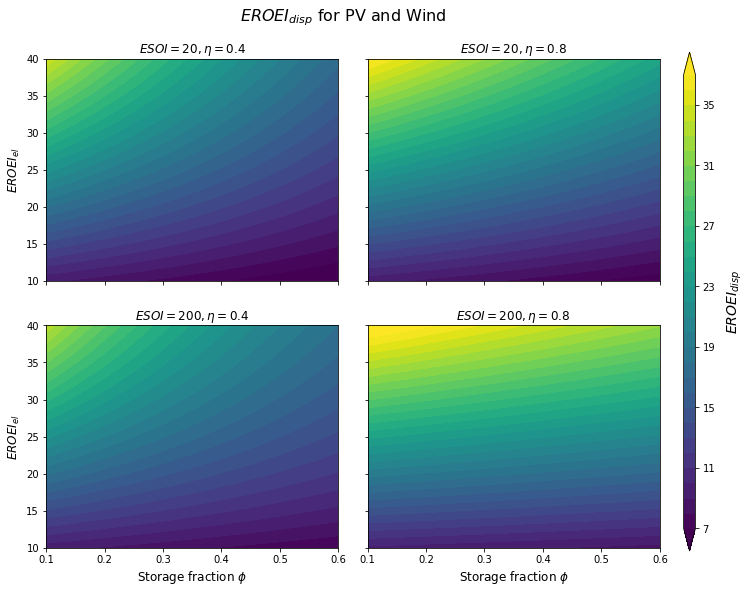

In [16]:
eroei_el=np.linspace(10,40,100)
phi=np.linspace(.10,.60,100)
ESOI=[20,200]
eta=[0.4,0.8]
eroei_disp=np.zeros([len(eta),len(ESOI),len(phi),len(eroei_el)])
for e in range(len(eta)):
    for i in range(len(ESOI)):
        for j in range(len(phi)):
            for k in range(len(eroei_el)):
                eroei_disp[e][i][k,j]=((1-phi[j])+(eta[e]*phi[j]))/((1/eroei_el[k])+(eta[e]*phi[j]/ESOI[i]))
fig,axes=plt.subplots(2,2,figsize=(11,9))
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.1)
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax=axes[i][j]
        z = eroei_disp[i][j]
        levels = MaxNLocator(nbins=30).tick_values(7, 37)
        cmap = plt.get_cmap('viridis')
        X, Y = np.meshgrid(phi, eroei_el)
        im = ax.contourf(X, Y, z, cmap=cmap, levels=levels,extend='both')
        if (i==0)and(j==1):
            fig.subplots_adjust(right=0.9)
            cbar_ax = fig.add_axes([0.93, 0.12, 0.015, 0.77])
            fig.colorbar(im, cax=cbar_ax)
            cbar_ax.set_ylabel(u'$EROEI_{disp}$',fontsize=14,labelpad=10)
        ax.set_xlim((phi.min(),phi.max()))
        ax.set_ylim((eroei_el.min(),eroei_el.max()))
        ax.set_title(u'$ESOI='+str(ESOI[i])+', \eta='+str(eta[j])+'$')
axes[1][0].set_xlabel('Storage fraction $\phi$',fontsize=12)
axes[1][1].set_xlabel('Storage fraction $\phi$',fontsize=12)
axes[0][0].set_ylabel('$EROEI_{el}$',fontsize=12)        
axes[1][0].set_ylabel('$EROEI_{el}$',fontsize=12)        
axes[0][1].set_yticklabels('')   
axes[1][1].set_yticklabels('')   
axes[0][0].set_xticklabels('')   
axes[0][1].set_xticklabels('')  
plt.suptitle(r'$EROEI_{disp}$ for PV and Wind',fontsize=16,y=0.96)
plt.savefig('RErnew2.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

Computing CCGT
Gas for EROEI
10.0 20.0 30.0 plotting...
Computing Pulverized
Coal for EROEI
7.0 10.5 14.0 plotting...
Computing IGCC
Coal for EROEI
8.0 11.5 15.0 plotting...


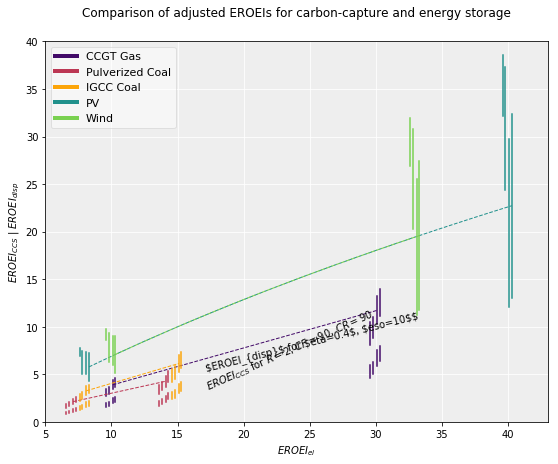

In [135]:
names=['CCGT\nGas','Pulverized\nCoal','IGCC\nCoal']
eroei_el_ns=[np.linspace(10,30,3),np.linspace(7,14,3),np.linspace(8,15,3)]   
fig, ax = plt.subplots(1,1,subplot_kw=dict(facecolor='#EEEEEE',axisbelow=True),figsize=(9,7))
ax.grid(color='white', linestyle='solid')                       
RR=[[2,3],[1,2],[1,2]]
def color(n):
    arr=range(n)
    return plt.get_cmap('viridis')(plt.Normalize(min(arr),max(arr))(arr))
def color2(n):
    arr=range(n)
    return plt.get_cmap('inferno')(plt.Normalize(min(arr),max(arr))(arr))
for n in range(len(names)):
    print 'Computing',names[n], 'for EROEI'
    R=RR[n]
    mmax=np.zeros([len(eroei_el_ns[n]),len(R),len(CF),len(CR_ratio),len(names)])
    mmin=np.zeros([len(eroei_el_ns[n]),len(R),len(CF),len(CR_ratio),len(names)])+1000
    for eroi in range(len(eroei_el_ns[n])):
        eroei_el=eroei_el_ns[n][eroi]
        print eroei_el,
        eroei_ccs=np.zeros([len(R),len(CF),len(fop),len(fcap)])
        for i in range(len(R)):
            for j in range(len(CF)):
                for k in range(len(fop)):
                    for l in range(len(fcap)):
                        for cr in range(len(CR_ratio)):
                            #calculate eoris over maps
                            eroei_ccs[i][j][l,k]=CR_ratio[cr]*((1-fop[k]/100.0)*((R[i]+1)/(R[i]+1+fcap[l]/100.0))*eroei_el*CF[j]*CF_ratio[j]/100.0)
                            #calculate minmaxes, all maps
                            for t0x in range(len(t0s[n])/2):
                                for t0y in range(len(t0s[n])/2,len(t0s[n])):
                                    x=t0s[n][t0x]
                                    y=t0s[n][t0y]
                                    if ((abs(fop[k]-x)<0.5)and(abs(fcap[l]-y)<1.5)):
                                        mmax[eroi][i][j][cr][n]=max(mmax[eroi][i][j][cr][n],eroei_ccs[i][j][l,k])
                                        mmin[eroi][i][j][cr][n]=min(mmin[eroi][i][j][cr][n],eroei_ccs[i][j][l,k])
    print 'plotting...'
    for i in range(len(R)):
        for j in range(len(CF)):
            for cr in range(len(CR_ratio)):
                x0=eroei_el_ns[n][0]+j*0.5+i*0.2-0.4
                y0min=mmin[0][i][j][cr][n]
                y0max=mmax[0][i][j][cr][n]
                x1=eroei_el_ns[n][-1]+j*0.5+i*0.2-0.4
                y1min=mmin[-1][i][j][cr][n]
                y1max=mmax[-1][i][j][cr][n]
                c=color2(11)[int(n*3+2)]
                lw=1.5
                if i==0:ls='-'
                else: ls='-'
                ax.plot([x0,x0],[y0min,y0max],c=c,lw=lw,ls=ls)
                ax.plot([x1,x1],[y1min,y1max],c=c,lw=lw,ls=ls)
                if ((i==0)&(j==1)&(cr==0)):
                    xk=eroei_el_ns[n][:]+j*0.5+i*0.2-0.4
                    ykmin=[mmin[z][i][j][cr][n] for z in range(len(mmin))]
                    ykmax=[mmax[z][i][j][cr][n] for z in range(len(mmax))]
                    ax.plot([0,0],[1,1],c=c,lw=4,label=names[n].replace('\n',' '))
                    ax.plot(xk,(np.array(ykmin)+np.array(ykmax))/2.0,c=c,lw=1,ls='--')
                    if (n==0):
                        ax.text(17, 11, r'$EROEI_{CCS}$ for $R='+str(R[i])+'$'+', $CF='+str(CF[j])+'$'+\
                                ', $CR='+str(CR[cr])+'$',color='black',rotation=24)

ren=['PV','Wind']
eroei_el_ren=[np.linspace(8,40,100),np.linspace(10,33,100)]
for n in range(len(ren)):
    eroei_el=eroei_el_ren[n]
    phi=np.linspace(.10,.60,100)
    ESOI=[200,10]
    eta=[0.8,0.4]
    eroei_disp=np.zeros([len(eta),len(ESOI),len(phi),len(eroei_el)])
    for e in range(len(eta)):
        for i in range(len(ESOI)):
            for k in range(len(eroei_el)):
                for j in range(len(phi)):
                    eroei_disp[e][i][k][j]=((1-phi[j])+(eta[e]*phi[j]))/((1/eroei_el[k])+(eta[e]*phi[j]/ESOI[i]))
            x0=eroei_el[0]+i*0.5+e*0.2-0.4
            y0min=min(eroei_disp[e][i][0])
            y0max=max(eroei_disp[e][i][0])
            x1=eroei_el[-1]+i*0.5+e*0.2-0.4
            y1min=min(eroei_disp[e][i][-1])
            y1max=max(eroei_disp[e][i][-1])
            c=color(11)[int(n*3+5)]
            ax.plot([x0,x0],[y0min,y0max],c=c,lw=lw,ls=ls)
            ax.plot([x1,x1],[y1min,y1max],c=c,lw=lw,ls=ls)
            if ((e==1)&(i==1)):
                xk=eroei_el[:]+i*0.5+e*0.2-0.4
                ykmin=[min(eroei_disp[e][i][z]) for z in range(len(eroei_disp[e][i]))]
                ykmax=[max(eroei_disp[e][i][z]) for z in range(len(eroei_disp[e][i]))]
                ax.plot([0,0],[1,1],c=c,lw=4,label=ren[n])
                ax.plot(xk,(np.array(ykmin)+np.array(ykmax))/2.0,c=c,lw=1,ls='--')
                if (n==0):
                        ax.text(17, 11, r'$EROEI_{disp}$ for $eta='+str(eta[e])+'$'+', $eso='+str(ESOI[i])+'$'+\
                                '$',color='black',rotation=14)

                

ax.set_xlim(5,43)
ax.set_ylim(0,40)
ax.legend(loc=2,framealpha=0.5,fontsize=11)
ax.set_ylabel("$EROEI_{CCS}$ | $EROEI_{disp}$")
ax.set_xlabel("$EROEI_{el}$")
#ax.set_yscale('log')
ax.set_title('Comparison of adjusted EROEIs for carbon-capture and energy storage',y=1.05)
#plt.savefig(str(r)+'e_new32.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

Computing CCGT
Gas for EROEI
10.0 20.0 30.0 plotting...
Computing Pulverized
Coal for EROEI
7.0 10.5 14.0 plotting...
Computing IGCC
Coal for EROEI
8.0 11.5 15.0 plotting...


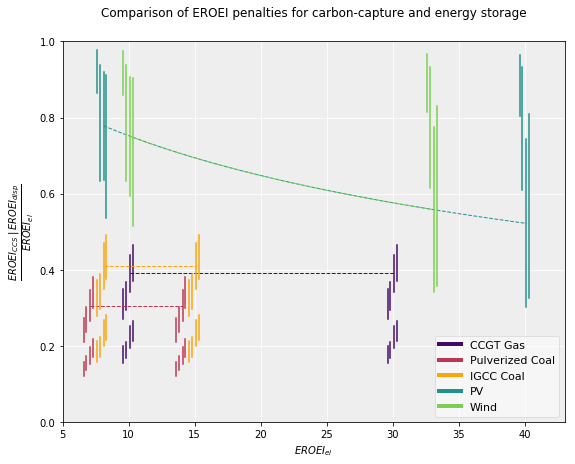

In [130]:
names=['CCGT\nGas','Pulverized\nCoal','IGCC\nCoal']
eroei_el_ns=[np.linspace(10,30,3),np.linspace(7,14,3),np.linspace(8,15,3)]   
fig, ax = plt.subplots(1,1,subplot_kw=dict(facecolor='#EEEEEE',axisbelow=True),figsize=(9,7))
ax.grid(color='white', linestyle='solid')                       
RR=[[2,3],[1,2],[1,2]]
def color(n):
    arr=range(n)
    return plt.get_cmap('viridis')(plt.Normalize(min(arr),max(arr))(arr))
def color2(n):
    arr=range(n)
    return plt.get_cmap('inferno')(plt.Normalize(min(arr),max(arr))(arr))
for n in range(len(names)):
    print 'Computing',names[n], 'for EROEI'
    R=RR[n]
    mmax=np.zeros([len(eroei_el_ns[n]),len(R),len(CF),len(CR_ratio),len(names)])
    mmin=np.zeros([len(eroei_el_ns[n]),len(R),len(CF),len(CR_ratio),len(names)])+1000
    for eroi in range(len(eroei_el_ns[n])):
        eroei_el=eroei_el_ns[n][eroi]
        print eroei_el,
        eroei_ccs=np.zeros([len(R),len(CF),len(fop),len(fcap)])
        for i in range(len(R)):
            for j in range(len(CF)):
                for k in range(len(fop)):
                    for l in range(len(fcap)):
                        for cr in range(len(CR_ratio)):
                            #calculate eoris over maps
                            eroei_ccs[i][j][l,k]=CR_ratio[cr]*((1-fop[k]/100.0)*((R[i]+1)/(R[i]+1+fcap[l]/100.0))*eroei_el*CF[j]*CF_ratio[j]/100.0)
                            eroei_ccs[i][j][l,k]/=eroei_el
                            #calculate minmaxes, all maps
                            for t0x in range(len(t0s[n])/2):
                                for t0y in range(len(t0s[n])/2,len(t0s[n])):
                                    x=t0s[n][t0x]
                                    y=t0s[n][t0y]
                                    if ((abs(fop[k]-x)<0.5)and(abs(fcap[l]-y)<1.5)):
                                        mmax[eroi][i][j][cr][n]=max(mmax[eroi][i][j][cr][n],eroei_ccs[i][j][l,k])
                                        mmin[eroi][i][j][cr][n]=min(mmin[eroi][i][j][cr][n],eroei_ccs[i][j][l,k])
    print 'plotting...'
    for i in range(len(R)):
        for j in range(len(CF)):
            for cr in range(len(CR_ratio)):
                x0=eroei_el_ns[n][0]+j*0.5+i*0.2-0.4
                y0min=mmin[0][i][j][cr][n]
                y0max=mmax[0][i][j][cr][n]
                x1=eroei_el_ns[n][-1]+j*0.5+i*0.2-0.4
                y1min=mmin[-1][i][j][cr][n]
                y1max=mmax[-1][i][j][cr][n]
                c=color2(11)[int(n*3+2)]
                lw=1.5
                if i==0:ls='-'
                else: ls='-'
                ax.plot([x0,x0],[y0min,y0max],c=c,lw=lw,ls=ls)
                ax.plot([x1,x1],[y1min,y1max],c=c,lw=lw,ls=ls)
                if ((i==0)&(j==1)&(cr==0)):
                    xk=eroei_el_ns[n][:]+j*0.5+i*0.2-0.4
                    ykmin=[mmin[z][i][j][cr][n] for z in range(len(mmin))]
                    ykmax=[mmax[z][i][j][cr][n] for z in range(len(mmax))]
                    ax.plot([0,0],[1,1],c=c,lw=4,label=names[n].replace('\n',' '))
                    ax.plot(xk,(np.array(ykmin)+np.array(ykmax))/2.0,c=c,lw=1,ls='--')
                    #if (n==0):
                    #    ax.text(17, 11, r'$EROEI_{CCS}$ for $R='+str(R[i])+'$'+', $CF='+str(CF[j])+'$'+\
                    #            ', $CR='+str(CR[cr])+'$',color='black',rotation=24)

ren=['PV','Wind']
eroei_el_ren=[np.linspace(8,40,100),np.linspace(10,33,100)]
for n in range(len(ren)):
    eroei_el=eroei_el_ren[n]
    phi=np.linspace(.10,.60,100)
    ESOI=[200,10]
    eta=[0.8,0.4]
    eroei_disp=np.zeros([len(eta),len(ESOI),len(phi),len(eroei_el)])
    for e in range(len(eta)):
        for i in range(len(ESOI)):
            for k in range(len(eroei_el)):
                for j in range(len(phi)):
                    eroei_disp[e][i][k][j]=((1-phi[j])+(eta[e]*phi[j]))/((1/eroei_el[k])+(eta[e]*phi[j]/ESOI[i]))
                    eroei_disp[e][i][k][j]/=eroei_el[k]
            x0=eroei_el[0]+i*0.5+e*0.2-0.4
            y0min=min(eroei_disp[e][i][0])
            y0max=max(eroei_disp[e][i][0])
            x1=eroei_el[-1]+i*0.5+e*0.2-0.4
            y1min=min(eroei_disp[e][i][-1])
            y1max=max(eroei_disp[e][i][-1])
            c=color(11)[int(n*3+5)]
            ax.plot([x0,x0],[y0min,y0max],c=c,lw=lw,ls=ls)
            ax.plot([x1,x1],[y1min,y1max],c=c,lw=lw,ls=ls)
            if ((e==0)&(i==1)):
                xk=eroei_el[:]+i*0.5+e*0.2-0.4
                ykmin=[min(eroei_disp[e][i][z]) for z in range(len(eroei_disp[e][i]))]
                ykmax=[max(eroei_disp[e][i][z]) for z in range(len(eroei_disp[e][i]))]
                ax.plot([0,0],[1,1],c=c,lw=4,label=ren[n])
                ax.plot(xk,(np.array(ykmin)+np.array(ykmax))/2.0,c=c,lw=1,ls='--')
                #if (n==0):
                #        ax.text(17, 11, r'$EROEI_{CCS}$ for $R='+str(R[i])+'$'+', $CF='+str(CF[j])+'$'+\
                #                ', $CR='+str(CR[cr])+'$',color='black',rotation=24)

                

ax.set_xlim(5,43)
ax.set_ylim(0,1)
ax.legend(framealpha=0.5,fontsize=11)
ax.set_ylabel("$\\frac{EROEI_{CCS}\\>|\\>EROEI_{disp}}{EROEI_{el}}$",fontsize=14)
ax.set_xlabel("$EROEI_{el}$")
#ax.set_yscale('log')
ax.set_title('Comparison of EROEI penalties for carbon-capture and energy storage',y=1.05)
plt.savefig(str(r)+'e_new22.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

CF plot

In [18]:
df=pd.read_excel('cfdata.xlsx')

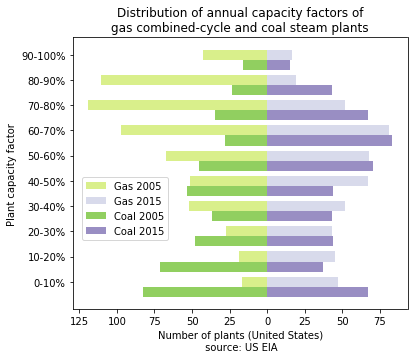

In [19]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.barh(df.index,df['PC 2005'],0.4,color='#d9ef8b',label='Gas 2005')
ax.barh(df.index,df['PC 2015'],0.4,color='#d8daeb',label='Gas 2015')
ax.barh(df.index-0.4,df['NG 2005'],0.4,color='#91cf60',label='Coal 2005')
ax.barh(df.index-0.4,df['NG 2015'],0.4,color='#998ec3',label='Coal 2015')
fig.canvas.draw()
labels = ['']+[item.get_text().replace(u'\u2212','') for item in ax.get_xticklabels()[1:-1]]+['']
ax.set_xticklabels(labels)
ax.set_yticks(df.index)
ax.set_yticklabels(df['CF'][::-1])
ax.legend(bbox_to_anchor=(0.3, 0.37))
ax.set_ylabel('Plant capacity factor')
ax.set_xlabel('Number of plants (United States)\n source: US EIA')
ax.set_title('Distribution of annual capacity factors of\ngas combined-cycle and coal steam plants')
plt.savefig('CFnew2.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

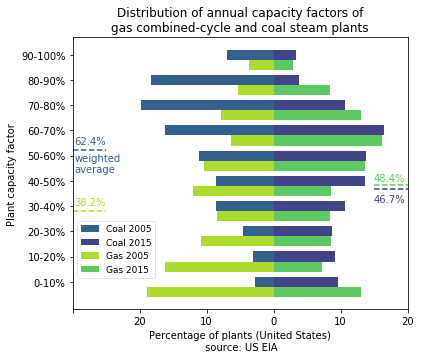

In [20]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.barh(df.index,-df['PC 2005']/sum(df['PC 2005'])*100,0.4,color=color(11)[3],label='Coal 2005')
ax.barh(df.index,df['PC 2015']/sum(df['PC 2015'])*100,0.4,color=color(11)[2],label='Coal 2015')
ax.barh(df.index-0.4,-df['NG 2005']/sum(df['NG 2005'])*100,0.4,color=color(9)[7],label='Gas 2005')
ax.barh(df.index-0.4,df['NG 2015']/sum(df['NG 2015'])*100,0.4,color=color(9)[6],label='Gas 2015')
z=np.average(df.index+0.5,weights=df['NG 2005'])-1
ax.plot([-30,-25],[z,z],ls='--',color=color(9)[7])
ax.text(-29.7,z+0.2,str(np.round((z+1)*10,1))+ '%',color=color(9)[7])
z=np.average(df.index+0.5,weights=df['NG 2015'])-1
ax.plot([15,20],[z,z],ls='--',color=color(9)[6])
ax.text(15,z+0.15,str(np.round((z+1)*10,1))+ '%',color=color(9)[6])
z=np.average(df.index+0.5,weights=df['PC 2005'])-1
ax.plot([-30,-25],[z,z],ls='--',color=color(11)[3])
ax.text(-29.7,z+0.2,str(np.round((z+1)*10,1))+ '%',color=color(11)[3])
ax.text(-29.7,z-0.9,'weighted\naverage',color=color(11)[3])
z=np.average(df.index+0.5,weights=df['PC 2015'])-1
ax.plot([15,20],[z,z],ls='--',color=color(11)[2])
ax.text(15,z-0.5,str(np.round((z+1)*10,1))+ '%',color=color(11)[2])


fig.canvas.draw()
labels = ['']+[item.get_text().replace(u'\u2212','') for item in ax.get_xticklabels()[2:-1]]+['']
ax.set_xticklabels(labels)
ax.set_yticks(df.index)
ax.set_xlim([-30,20])
ax.set_yticklabels(df['CF'][::-1])
ax.legend(bbox_to_anchor=(0.26, 0.22),framealpha=0.5,fontsize=9)
ax.set_ylabel('Plant capacity factor')
ax.set_xlabel('Percentage of plants (United States)\n source: US EIA')
ax.set_title('Distribution of annual capacity factors of\ngas combined-cycle and coal steam plants')
plt.savefig('CFnew3.png',dpi=150,bbox_inches = 'tight', pad_inches = 0.1)
plt.show()